# ResNet50 Classifier

To provide a comparable model for the HOG/SVM classfier, we use a common Convolutional Neural Network (CNN) architecture: **ResNet50**.

ResNet models are built using **Residual Blocks**, which help deep networks to avoid degradation in training error [1].

![Pull quote from original ResNet paper](img/00-resnet-text.png) 

> [1] K. He, X. Zhang, S. Ren, and J. Sun, “Deep residual learning for image recognition,” Proc. IEEE Comput. Soc. Conf. Comput. Vis. Pattern Recognit., vol. 2016-December, pp. 770–778, 2016.

## Tensorflow Dataset iterator

The X-ray dataset is large enough that we do not want to keep all of it in memory at the same time.

The `tf.data.Dataset` API allows us to create a cache which streams data from a directory, alleviating the memory burden on the Python process.

In [1]:
# load images with tf.data.Dataset
# see here: https://www.tensorflow.org/tutorials/load_data/images
import tensorflow as tf
print("Tensorflow version: {}".format(tf.__version__))
import pandas as pd
import numpy as np
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE
import pathlib
from code.dataset import *

SCALE_DOWN_FACTOR = 2
df_sizes = pd.read_csv("data/data/sorted_metadata.csv")
BATCH_SIZE = 16
IMG_HEIGHT = int(df_sizes.n_rows.mean()/SCALE_DOWN_FACTOR)
IMG_WIDTH = int(df_sizes.n_cols.mean()/SCALE_DOWN_FACTOR)
CLASS_NAMES = np.array(["Normal", "Pnemonia"])
print("--- Training on images of size ({},{}) ---".format(IMG_WIDTH,IMG_HEIGHT)) # change this in dataset file

Tensorflow version: 2.0.0
--- Training on images of size (664,486) ---


In [2]:
path="data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
# train_path = f"{path}/train_modified" # train on all images
train_path = f"{path}/train_unique" # train on images from unique patients
data_dir = pathlib.Path(train_path)
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [4]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Define a file (`filename`) which we will use to cache upcoming samples.

In [5]:
filename = 'data/train_cache'
train_ds = prepare_for_training(labeled_ds,cache=filename,BATCH_SIZE=BATCH_SIZE,AUTOTUNE=AUTOTUNE)

## Inspect a batch of images from the generator

/home/mason_delro_gmail_com/git/sta208-covid19-xray/code/dataset.py:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.title(CLASS_NAMES[tf.where(label_batch[n]==1)][0].title())


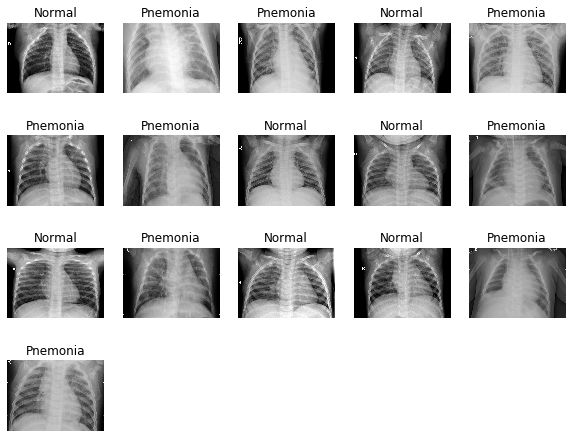

In [7]:
image_batch, label_batch = next(iter(train_ds)) # sample the Dataset iterator
show_batch(image_batch.numpy(), label_batch.numpy(), BATCH_SIZE)

## Load ResNet50 from Keras

In [6]:
data_format = "channels_last"
inp_shape = (IMG_HEIGHT,IMG_WIDTH,1) # channels_last
input_tensor = None
resnet = tf.keras.applications.ResNet50(
    include_top=True, weights=None, input_tensor=input_tensor, input_shape=inp_shape,
    pooling=None, classes=2
)

df_sizes = pd.read_csv("data/unique_sorted_metadata.csv")
path="data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
num_examples = df_sizes[df_sizes.dataset_type == "TRAIN"].shape[0]
full_batches = num_examples // BATCH_SIZE
print(full_batches)

162


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

epochs=100
# model_path = "model/resnet50"
# model_json = resnet.to_json()
# model_out_base = "{}/model_H{}_W{}_unique_".format(model_path,IMG_HEIGHT,IMG_WIDTH)

## TO-DO:

checkpoint = ModelCheckpoint(
    filepath="weights/resnet50/H486_W664/weights-{epoch:02d}.h5", # clunky, but Keras' str.format requires particular keywords to work
    #filepath="model/resnet50/model_test.h5", # clunky, but Keras' str.format requires particular keywords to work
    save_weights_only=True,
    monitor='accuracy',
    # save_freq='epoch'
    save_freq=full_batches
)

In [8]:
resnet.compile(optimizer='adam',
               loss=tf.keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy']
              ) 
resnet.summary()
resnet.fit(train_ds,
           epochs=epochs,
           steps_per_epoch=full_batches,
           callbacks=[checkpoint],
           verbose=1)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 486, 664, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 492, 670, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 243, 332, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 243, 332, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [9]:
# test model on training set for now
resnet.evaluate(train_ds,steps=full_batches)

162/162 [==============================] - 547s 3s/step - loss: 4.9652 - accuracy: 0.5235


[4.965153073823011, 0.52353394]

Model performance at different epochs is summarized in `test-resnet.ipynb`